In [3]:
import numpy as np  
from astropy import units as u
import matplotlib.pyplot as plt

h = 120 * u.cm #cm 
r = 180 * u.cm #cm 


m0 = 105.6583745 * u.MeV# MeV, muon mass
me = 0.510998950 * u.MeV # MeV, electron mass 


def _beta(ek):
    return np.sqrt(ek*ek + 2*ek*m0) / (ek+m0) 
def _gamma(ek): 
    return 1 / np.sqrt( 1 - _beta(ek)*_beta(ek) ) 
def _Wmax(_ek):
    tmp_beta = _beta(_ek)
    tmp_gamma = _gamma(_ek)
    return 2*me*(tmp_beta*tmp_gamma)**2 / (1 + 2*tmp_gamma*me / m0 + (me / m0)**2  )

# Define the Bethe formula as a funcion, with the muon kinetic energy as argument. Dimension of dE/dx is MeV/cm 

def de_dx(_beta,_gamma, _Wmax):
    return K*Z_A*(1/_beta**2) * (0.5 *np.log(2*me* _beta**2 *_gamma**2 * _Wmax / I**2) - _beta**2 ) * rho  


In [4]:
# Look up material properties (water)
# https://pdg.lbl.gov/2024/AtomicNuclearProperties/HTML/water_liquid.html  

Z_A=0.55509 *u.mol / u.g #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 * u.g / u.cm**3 #g cm^-3, density of liquid water 
I=7.97e-5 * u.MeV #MeV, mean excitation energy

K=0.307075 * u.MeV * u.cm **2 / u.mol #MeV mol^−1 cm2


In [5]:
# Try splitting the muon path inside the tank into smaller steps of dx = 10 cm
# Update energy of muon after each step  

print('*****  Computing dE/dx in steps across the tank *****\n')

def _eloss_step(_beta,_gamma,_Wmax,_dx): 
    _eloss = de_dx(_beta,_gamma,_Wmax) * _dx 
    print('Step energy loss: ', _eloss)
    return _eloss

dx = 10 * u.cm #cm 

# As a first check, compute energy loss for a dx = 10 cm step in water  

# Initialize again 1 GeV muon
ek = 1000 * u.MeV # MeV
beta = _beta(ek)
gamma = _gamma(ek)
Wmax = _Wmax(ek)

eloss = _eloss_step(beta,gamma,Wmax,dx)

# Update kinetic energy, beta and gamma
ek = ek - eloss  
beta = _beta(ek)
gamma = _gamma(ek)  
Wmax = _Wmax(ek)
print('Muon energy after one step: ', ek)

*****  Computing dE/dx in steps across the tank *****

Step energy loss:  22.54684241632768 MeV
Muon energy after one step:  977.4531575836724 MeV


In [6]:
# Now compute energy loss with nsteps to cover the full height of the tank (h = 120 cm )

print('*****  Now iterate steps for the full height of the tank *****\n')

# Initialize again 1 GeV muon

ek = 1000. * u.MeV # re-set the energy to 1 GeV  
beta = _beta(ek)
gamma = _gamma(ek)
Wmax = _Wmax(ek)

nsteps = int(h/dx)
tot_eloss = 0. * u.MeV

# Initialize arrays to save energy loss and beta*gamma at each step 
eloss_array = np.zeros(nsteps) * u.MeV * u.cm**2 / u.g
bg_array = np.zeros(nsteps)

for i in range(nsteps): 
    eloss = _eloss_step(beta, gamma, Wmax, dx)
    tot_eloss += eloss
     
    # Update particle 
    ek = ek - eloss  
    beta = _beta(ek)
    gamma = _gamma(ek)
    Wmax = _Wmax(ek)

    eloss_array[i] = eloss / (dx * rho)
    bg_array[i] = beta * gamma
    
print('\nMuon kinetic energy after passage in the tank: ', ek)    
print('Total energy deposited in the tank:', tot_eloss)
print('Check: ', ek + tot_eloss )


*****  Now iterate steps for the full height of the tank *****

Step energy loss:  22.54684241632768 MeV
Step energy loss:  22.486282885916154 MeV
Step energy loss:  22.424913733689166 MeV
Step energy loss:  22.362724371117842 MeV
Step energy loss:  22.299705198022245 MeV
Step energy loss:  22.23584784769118 MeV
Step energy loss:  22.17114547870078 MeV
Step energy loss:  22.105593122749543 MeV
Step energy loss:  22.03918809988977 MeV
Step energy loss:  21.971930515104305 MeV
Step energy loss:  21.903823853401715 MeV
Step energy loss:  21.834875694667755 MeV

Muon kinetic energy after passage in the tank:  733.617126782722 MeV
Total energy deposited in the tank: 266.38287321727813 MeV
Check:  1000.0000000000002 MeV


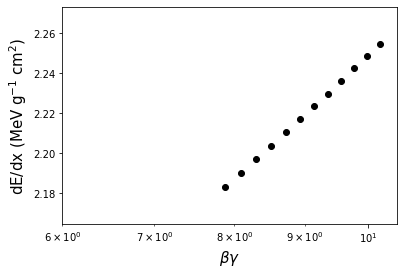

In [7]:
# Plot dE/dx as a function of beta*gamma 

plt.xscale('log')
plt.xlim(6,10.5)
plt.xlabel(r'$\beta \gamma$', size = 15)
plt.ylabel(r'dE/dx (MeV g$^{-1}$ cm$^{2}$)', size =  15)
plt.scatter(bg_array, eloss_array, c='black')

In [8]:
# In this way we have computed the energy loss based on the mean rate given by the Bethe formula
# Now let's take into account the energy loss probability distribution, described by a Landau distribution   
# Install landaupy with "pip install git+https://github.com/SengerM/landaupy"

from landaupy import landau

# Define function to compute energy loss from a Landau distribution at each step 
 
def _eloss_step_landau(_beta,_gamma,_dx):
    
    # Width of the Landau 
    width =  K/2*Z_A*(_dx*rho/_beta**2) 
    
    # MPV of the Landau 
    mpv = width \
            *( np.log(2*me*_beta**2*_gamma**2/I) \
                +np.log(width/I) + 0.2
                         -_beta**2 )
    
    # Extract a value from the Landau distribution         
    _eloss = landau.sample(x_mpv=mpv.value, xi=width.value, n_samples=1) 
    
    print('Step energy loss: ', _eloss, 'MeV')
    return _eloss * u.MeV


In [9]:
# Now let's simulate steps inside the tank, each time extracting the energy loss from the Landau distribution

print('*****  Iterate steps for the full height of the tank *****')
print('*****  computing energy loss from a Landau distribution *****\n')

ek = 1000. * u.MeV # reset primary kinetic energy 
beta = _beta(ek)
gamma = _gamma(ek)
Wmax = _Wmax(ek)

d_eloss_array = np.zeros(nsteps) * u.MeV
tot_eloss_landau = 0. * u.MeV 
 
for i in range(nsteps): 
    eloss = _eloss_step_landau(beta,gamma,dx)
    tot_eloss_landau += eloss 
    d_eloss_array[i] = eloss
    tot_eloss += eloss
     
    # Update particle 
    ek = ek - eloss  
    beta = _beta(ek)
    gamma = _gamma(ek)
    Wmax = _Wmax(ek)
    
print('\nMuon kinetic energy after passage in the tank: ', ek)    
print('Total energy deposited in the tank:', tot_eloss_landau)

*****  Iterate steps for the full height of the tank *****
*****  computing energy loss from a Landau distribution *****

Step energy loss:  18.981381562930427 MeV
Step energy loss:  39.89605455874493 MeV
Step energy loss:  19.367249584091923 MeV
Step energy loss:  19.25713891611878 MeV
Step energy loss:  21.03500660789943 MeV
Step energy loss:  21.85346138023115 MeV
Step energy loss:  22.3357228607072 MeV
Step energy loss:  20.686441451727603 MeV
Step energy loss:  19.910371068308706 MeV
Step energy loss:  19.174427565262185 MeV
Step energy loss:  18.43943063999051 MeV
Step energy loss:  21.240629098085996 MeV

Muon kinetic energy after passage in the tank:  737.8226847059013 MeV
Total energy deposited in the tank: 262.17731529409883 MeV


(array([0., 0., 0., 0., 0., 0., 0., 0., 4., 2., 3., 2., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([10.        , 11.03448276, 12.06896552, 13.10344828, 14.13793103,
        15.17241379, 16.20689655, 17.24137931, 18.27586207, 19.31034483,
        20.34482759, 21.37931034, 22.4137931 , 23.44827586, 24.48275862,
        25.51724138, 26.55172414, 27.5862069 , 28.62068966, 29.65517241,
        30.68965517, 31.72413793, 32.75862069, 33.79310345, 34.82758621,
        35.86206897, 36.89655172, 37.93103448, 38.96551724, 40.        ]),
 <a list of 1 Patch objects>)

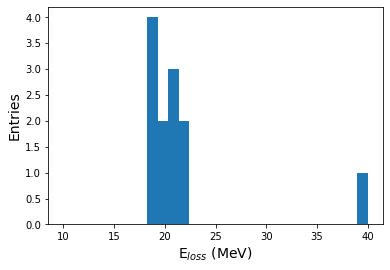

In [10]:
plt.xlabel(r'E$_{loss}$ (MeV)', size = 14)
plt.ylabel('Entries', size = 14)
plt.hist(d_eloss_array.value, bins = np.linspace(10,40,30), histtype='stepfilled')
